In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,339.485173,10.951135,19.617252,31
"Mexican Gothic, Moreno-Garcia",748.024637,26.715166,47.539879,28
Azure Functions Core Tools,540.448917,31.791113,44.669403,17
Node.js and Vite,2030.717247,49.529689,77.518601,41
Django,1997.543542,49.938589,71.675555,40
Python,4535.808649,58.151393,179.258505,78
VMWare,60.937292,60.937292,60.937292,1
Azure Files Documentation,3766.219214,62.770320,157.007389,60
Active Directory and Azure Files,2574.616852,69.584239,111.794447,37
CCH Tax Forms Project,1493.791963,71.132951,147.575361,21


# Histogram

sum of ages: ~52066.63


<Axes: >

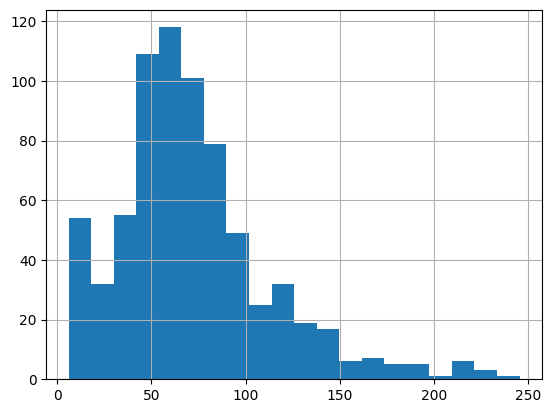

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52066.63


<Axes: >

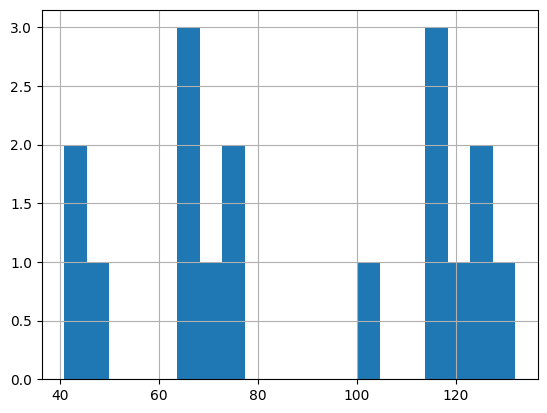

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Asynchronous Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 724
Total card age: 52066.63


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
100,VMWare,vMotion Compatibility\n\nThe requirement for s...,fe45515c57f95e8f15b96ff122b0c0d1,60.937292,60.937292,-60.937292,60.937292,0.605505,1,0,0,-60.937292
80,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,119.420108,78.922619,-119.420108,394.613095,0.067582,5,0,0,-119.420108
81,C# Basics,Reflection allows you to inspect the metadata ...,5217d06cf147b4ce8934bb826d7d35a9,97.375604,78.922619,-119.420108,394.613095,0.067582,5,1,0,-97.375604
82,C# Basics,What is the role of namespaces in C#?\n\nC#: N...,6da4c96ee60a0c2ee0dc4f9fcab95060,77.093138,78.922619,-119.420108,394.613095,0.067582,5,2,0,-77.093138
83,C# Basics,Indexers allow objects to be indexed like arra...,8b8cd7dfc49d7351086701c7627b6136,56.308411,78.922619,-119.420108,394.613095,0.067582,5,3,0,-56.308411
84,C# Basics,How do basic data types work in C#?\n\nC#: Sta...,9bcbb2098a72dbaa4a613d64f34446be,44.415834,78.922619,-119.420108,394.613095,0.067582,5,4,0,-44.415834
35,Azure VM + Developer,Dotfiles\nA collection of personal configurati...,bc791352f938ed873353ee48a848a43e,180.800020,106.523828,-180.800020,852.190626,0.373138,8,0,0,-180.800020
36,Azure VM + Developer,Persistent vs Ephemeral\nA comparison between ...,f48c369683c21c344770b3ebc17f7427,131.779541,106.523828,-180.800020,852.190626,0.373138,8,1,0,-131.779541
37,Azure VM + Developer,.ssh/known_hosts\nA file used by SSH to store ...,d4f9279a08485d568b293f2c2f417297,111.570919,106.523828,-180.800020,852.190626,0.373138,8,2,0,-111.570919
38,Azure VM + Developer,Linter\nA code analysis tool that detects erro...,701555d6da9b6657e7601179a0dd9015,102.425010,106.523828,-180.800020,852.190626,0.373138,8,3,0,-102.425010



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(982.125876597276)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,245.354628,94.046709,-245.354628,3009.494698,0.269822,32,0,0,-245.354628
5,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,232.305613,95.703290,-232.305613,2583.988821,0.067250,27,0,0,-232.305613
15,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,223.974679,95.031751,-223.974679,4751.587533,0.124264,50,0,0,-223.974679
10,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,223.530344,104.654693,-223.530344,1883.784478,0.457641,18,0,0,-223.530344
6,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,220.972533,95.703290,-232.305613,2583.988821,0.067250,27,1,0,-220.972533
20,Vocab,Anacoluthon\nnoun\nSPA: an-uh-koh-LOO-thon\nIP...,58fe2f5c535300af7c826eb1cff7d208,220.553156,97.670783,-220.553156,2441.769580,0.597867,25,0,0,-220.553156
25,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,213.084071,104.396251,-213.084071,5011.020052,0.972699,48,0,0,-213.084071
16,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,212.681356,95.031751,-223.974679,4751.587533,0.124264,50,1,0,-212.681356
26,Microsoft Purview,Define what each label can do. Configure the p...,2314da7a2bfdaa36bc1e3f2e5633935f,210.818793,104.396251,-213.084071,5011.020052,0.972699,48,1,0,-210.818793
11,Azure Compute Gallery,Subscription Quotas – Limits on the number of ...,ccb8c05118173479053ff181ddffe698,209.843317,104.654693,-223.530344,1883.784478,0.457641,18,1,0,-209.843317


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 71.915'